In [229]:
%matplotlib ipympl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from typing import Optional, Tuple

sns.set_theme(palette='colorblind')

# Data Cleaning and Preprocessing of Titanic Dataset


## Load the Processed Datasets


In [230]:
df_labelled = pd.read_pickle('dataset\\df_labelled.pkl')
df_unlabelled = pd.read_pickle('dataset\\df_unlabelled.pkl')

We use the `pivot_survival_table` function to check the survival rate for different values of the features that will be created from the pre-existing ones.

In [231]:
def pivot_survival_table(df, target_column):
    df_pivot = pd.pivot_table(
        df[['PassengerId', target_column, 'Survived']],
        index=target_column,
        columns='Survived',
        aggfunc='count',
        fill_value=0
    ).reset_index()

    df_pivot.columns = [target_column, 'Not Survived', 'Survived']
    df_pivot['Num of passengers'] = df_pivot['Not Survived'] + df_pivot['Survived']
    df_pivot['Survival Rate (%)'] = (df_pivot['Survived'] / df_pivot['Num of passengers']) * 100

    return df_pivot

## Feature Engineering - Part 1


Feature engineering aims to create new features from existing ones in order to improve the performance of the model. It is performed on both the labelled and unlabelled datasets to avoid differences in dataframe structure.

### New features: `Family_num`, `Family_size`


In [232]:
def get_family(df: pd.DataFrame) -> pd.DataFrame:
    df['Family_num'] = df['SibSp'] + df['Parch'] + 1

    def family_size(size: int):
        if size == 1:
            return 'Single'
        elif 2 <= size <= 4:
            return 'Small'
        elif 5 <= size <= 7:
            return 'Medium'
        else:
            return 'Large'
    
    df['Family_size'] = df.apply(lambda row: family_size(row['Family_num']), axis=1)
    return df

df_labelled = get_family(df_labelled)
df_unlabelled = get_family(df_unlabelled)

The `Family_num` characteristic is created by summing the `SibSp` and `Parch` characteristics plus one (to include the passengers themselves). This characteristic represents the total number of members of that family. The `Family_size` characteristic groups families into 4 different categories:

- 'Single' if `Family_num == 1`.
- Small' if `2 <= Family_num <= 4`.
- Medium' if `5 <= Family_number <= 7`.
- Large' if `Number_of_family >= 8`.

We check the survival rate for the different groups, using the `pivot_survival_table` function.

In [233]:
pivot_survival_table(df_labelled, 'Family_size')

,Family_size,Not Survived,Survived,Num of passengers,Survival Rate (%)
0,Large,13,0,13,0.000000
1,Medium,39,10,49,20.408163
2,Single,374,163,537,30.353818
3,Small,123,169,292,57.876712


From the table we see that the class with the highest survival rate is that of the 'small' (57.88%), i.e. households with 2 or 3 members. Large' families are basically doomed. Both 'Single' and 'Medium' families have a lower than average probability of survival (38.38%).

### New features from names


From the names we can get the title, first name and surname.

In [234]:
df_labelled['Dataset'] = 'labelled'
df_unlabelled['Dataset'] = 'unlabelled'

df_merged = pd.concat([df_labelled, df_unlabelled], ignore_index=True)
df_merged.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age Category,Family_num,Family_size,Dataset
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,adult,2,Small,labelled
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult,2,Small,labelled
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,adult,1,Single,labelled
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult,2,Small,labelled
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult,1,Single,labelled
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,no age,1,Single,labelled
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,adult,1,Single,labelled
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,child,5,Medium,labelled
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,adult,3,Small,labelled
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,adult,2,Small,labelled


In [235]:
df_merged['Name'][[i for i in np.random.randint(0, len(df_merged), 50)]]

907                                     Keane, Mr. Daniel
860                               Hansen, Mr. Claus Peter
485                                Lefebre, Miss. Jeannie
1025                               Dintcheff, Mr. Valtcho
1291                              Bonnell, Miss. Caroline
66                           Nye, Mrs. (Elizabeth Ramell)
42                                    Kraeff, Mr. Theodor
513        Rothschild, Mrs. Martin (Elizabeth L. Barrett)
965                                  Geiger, Miss. Amalie
597                                   Johnson, Mr. Alfred
819                          Skoog, Master. Karl Thorsten
199                Yrois, Miss. Henriette ("Mrs Harbeck")
927                                   Roth, Miss. Sarah A
607                           Daniel, Mr. Robert Williams
1082                               Salomon, Mr. Abraham L
1251                          Sage, Master. William Henry
1058                              Ford, Mr. Edward Watson
422           

As we can see, the `Name` column has a recurring format: `<surname>, <title> <name> (<other name optional>)`.

In [236]:
def split_name(name: str):
    first_second = name.split(".")
    first = first_second[0].split(",")
    surname = first[0].strip()
    title = first[1].strip()
    second = first_second[1].split("(")
    if second[0].strip():
        name = second[0].strip()
    else:
        name = second[1][:-1].strip()
    return title, name, surname

df_merged[['Title', 'First', 'Last']] = df_merged.apply(lambda row: split_name(row['Name']), axis=1, result_type='expand')
df_merged.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age Category,Family_num,Family_size,Dataset,Title,First,Last
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,adult,2,Small,labelled,Mr,Owen Harris,Braund
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult,2,Small,labelled,Mrs,John Bradley,Cumings
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,adult,1,Single,labelled,Miss,Laina,Heikkinen
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult,2,Small,labelled,Mrs,Jacques Heath,Futrelle
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult,1,Single,labelled,Mr,William Henry,Allen
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,no age,1,Single,labelled,Mr,James,Moran
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,adult,1,Single,labelled,Mr,Timothy J,McCarthy
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,child,5,Medium,labelled,Master,Gosta Leonard,Palsson
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,adult,3,Small,labelled,Mrs,Oscar W,Johnson
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,adult,2,Small,labelled,Mrs,Nicholas,Nasser


In [237]:
last_pivot = pd.pivot_table(
    df_merged,
    values='Name',
    index='Last',
    columns='Dataset',
    aggfunc='count'
).sort_values(['labelled'], ascending=False)

last_pivot

Dataset,labelled,unlabelled
Last,,
Andersson,9.0,2.0
Sage,7.0,4.0
Goodwin,6.0,2.0
Panula,6.0,NaN
Johnson,6.0,NaN
...,...,...
Wilson,NaN,1.0
Wirz,NaN,1.0
Wittevrongel,NaN,1.0


It can be seen that there are names that compare in the labelled set but not in the unlabelled set. The model would then be able to extract information from the names in the labelled set for use with the unlabelled set.

In [238]:
print(f"The number of families that are only in the labelled set: {len(last_pivot[last_pivot.unlabelled.isnull()])}")
print(f"The number of families that are only in the unlabelled set: {len(last_pivot[last_pivot.labelled.isnull()])}")
print(f"The number of families that are in both sets: {len(last_pivot[last_pivot.notnull().all(axis=1)])}")

The number of families that are only in the labelled set: 523
The number of families that are only in the unlabelled set: 208
The number of families that are in both sets: 144


In total there are 208 + 523 = 731 households. Of these, only 144 are present in both datasets.

In [239]:
df_labelled[['Title', 'First', 'Last']] = df_labelled.apply(lambda row: split_name(row['Name']), axis=1, result_type='expand')
df_unlabelled[['Title', 'First', 'Last']] = df_unlabelled.apply(lambda row: split_name(row['Name']), axis=1, result_type='expand')

Let's check the `Title` column

In [240]:
df_labelled['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

Many of these titles are quite rare, if not unique. Some are misspelled, such as 'Ms' and 'Mlle', like Mademoiselle, for 'Miss', or 'Mme', like Madame, for 'Mrs'.

In [241]:
def rename_title(df: pd.DataFrame) -> pd.DataFrame:
    df.loc[df['Title'] == 'Dr', 'Title'] = 'Rare Title'
    df.loc[df['Title'] == 'Rev', 'Title'] = 'Rare Title'
    df.loc[df['Title'] == 'Col', 'Title'] = 'Rare Title'
    df.loc[df['Title'] == 'Mlle', 'Title'] = 'Miss'
    df.loc[df['Title'] == 'Major', 'Title'] = 'Rare Title'
    df.loc[df['Title'] == 'Ms', 'Title'] = 'Miss'
    df.loc[df['Title'] == 'Mme', 'Title'] = 'Mrs'
    df.loc[df['Title'] == 'Don', 'Title'] = 'Rare Title'
    df.loc[df['Title'] == 'Lady', 'Title'] = 'Rare Title'
    df.loc[df['Title'] == 'Sir', 'Title'] = 'Rare Title'
    df.loc[df['Title'] == 'Capt', 'Title'] = 'Rare Title'
    df.loc[df['Title'] == 'the Countess', 'Title'] = 'Rare Title'
    df.loc[df['Title'] == 'Jonkheer', 'Title'] = 'Rare Title'

    return df

df_labelled = rename_title(df_labelled)
df_unlabelled = rename_title(df_unlabelled)

In [242]:
pivot_survival_table(df_labelled, 'Title')

,Title,Not Survived,Survived,Num of passengers,Survival Rate (%)
0,Master,17,23,40,57.500000
1,Miss,55,130,185,70.270270
2,Mr,436,81,517,15.667311
3,Mrs,26,100,126,79.365079
4,Rare Title,15,8,23,34.782609


As can be seen, persons with the title 'Miss' and 'Mrs', i.e. women, obtained the highest survival rates (70.27% and 79.37%). Amongst the men, only those with the title 'Master' had a higher than average survival rate (38.38%).

### New features from Ticket

From Ticket we will extract the following characteristics:
- Prefix (e.g. AB 51 -> AB),
- Length of the ticket number (e.g. AB 51 -> 2),
- Group size of the ticket number (count the number of people sharing the same number),
- Binomial of the ticket number (divide the numbers into 4 binomials (quartiles)).

These features may be meaningless or useless, we will find out later.

In [243]:
def process_ticket_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts features from Titanic 'Ticket' column:
    - ticket_prefix: categorical code before the number
    - ticket_number: numeric part (if present)
    - ticket_group_size: how many passengers share this ticket
    - ticket_len: length of the ticket string
    """

    # Normalize ticket strings
    tickets = df['Ticket'].astype(str).str.upper().str.strip()

    # Extract prefix (anything before the last number block)
    def extract_prefix(ticket: str):
        # Check if ticket is purely numeric
        if re.match(r'^\d+$', ticket.strip()):
            return "NoPrefix"
        match = re.match(r"^([A-Z0-9./\s]+?)\s*\d*$", ticket.strip())
        if match:
            prefix = match.group(1).strip().replace('.', '').replace('/', '')
            return prefix if prefix else "NoPrefix"
        return "NoPrefix"

    df['Ticket_prefix'] = tickets.apply(extract_prefix)

    # Extract numeric part
    def extract_number(ticket):
        match = re.search(r"(\d+)$", ticket)
        return int(match.group(1)) if match else -1  # -1 if no number
    df['Ticket_number'] = tickets.apply(extract_number)

    # Length of ticket number
    df['Ticket_len'] = df['Ticket_number'].astype(str).str.len()

    # Ticket group size (passengers with same ticket)
    df['Ticket_group_size'] = df.groupby('Ticket')['Ticket'].transform('count')

    # Bin numeric ticket into ranges
    df['Ticket_number_bin'] = pd.qcut(
        df.loc[df['Ticket_number'] > 0, 'Ticket_number'], 
        q=4, 
        labels=['low', 'midlow', 'midhigh', 'high']
    ).astype(str)
    df.loc[df['Ticket_number'] <= 0, 'Ticket_number_bin'] = "missing"
    
    df.drop(columns=['Ticket_number'])

    return df

# Example usage with Titanic dataset
df_labelled = process_ticket_features(df_labelled)
df_unlabelled = process_ticket_features(df_unlabelled)

In [244]:
pivot_survival_table(df_labelled, 'Ticket_prefix').sort_values('Num of passengers', ascending=False)
                                                #.sort_values('Survival Rate (%)', ascending=False)

,Ticket_prefix,Not Survived,Survived,Num of passengers,Survival Rate (%)
10,NoPrefix,407,254,661,38.426626
11,PC,21,39,60,65.000000
4,CA,27,14,41,34.146341
1,A5,19,2,21,9.523810
24,SOTONOQ,13,2,15,13.333333
26,STONO 2,7,5,12,41.666667
19,SCPARIS,6,5,11,45.454545
29,WC,9,1,10,10.000000
0,A4,7,0,7,0.000000
20,SOC,5,1,6,16.666667


The table shows that:
- Most passengers without a prefix have a survival rate that almost perfectly matches the average (38.42% vs. 38.38%).
- Those with a "PC" prefix have a survival rate of 65%.
- There are some prefixes with a survival rate of 100% (SWPP, SC, SCAH BASLE), but the number of tickets to which they belong is negligible.

In [245]:
pivot_survival_table(df_labelled, 'Ticket_len').sort_values('Num of passengers', ascending=False)

,Ticket_len,Not Survived,Survived,Num of passengers,Survival Rate (%)
5,6,288,135,423,31.914894
4,5,107,139,246,56.504065
3,4,113,52,165,31.515152
6,7,32,12,44,27.272727
2,3,4,3,7,42.857143
1,2,3,1,4,25.000000
0,1,2,0,2,0.000000


The table shows that those with a ticket length of 5 have the highest survival rate of 56.6%.

In [246]:
pivot_survival_table(df_labelled, 'Ticket_group_size').sort_values('Survival Rate (%)', ascending=False)
# .sort_values('Num of passengers', ascending=False)

,Ticket_group_size,Not Survived,Survived,Num of passengers,Survival Rate (%)
2,3,19,44,63,69.841270
1,2,80,108,188,57.446809
3,4,22,22,44,50.000000
0,1,384,163,547,29.798903
6,7,16,5,21,23.809524
4,5,10,0,10,0.000000
5,6,18,0,18,0.000000


In [247]:
pivot_survival_table(df_labelled, 'Family_num').sort_values('Survival Rate (%)', ascending=False)

,Family_num,Not Survived,Survived,Num of passengers,Survival Rate (%)
3,4,8,21,29,72.413793
2,3,43,59,102,57.843137
1,2,72,89,161,55.279503
6,7,8,4,12,33.333333
0,1,374,163,537,30.353818
4,5,12,3,15,20.000000
5,6,19,3,22,13.636364
7,8,6,0,6,0.000000
8,11,7,0,7,0.000000


In [248]:
pivot_survival_table(df_labelled, 'Family_size').sort_values('Survival Rate (%)', ascending=False)

,Family_size,Not Survived,Survived,Num of passengers,Survival Rate (%)
3,Small,123,169,292,57.876712
2,Single,374,163,537,30.353818
1,Medium,39,10,49,20.408163
0,Large,13,0,13,0.000000


From the table it can be seen that this characteristic seems to correlate positively with `family_number` and `family_size`, as small families have a high survival rate (55.28% - 72.41%).

In [249]:
pivot_survival_table(df_labelled, 'Ticket_number_bin').sort_values('Num of passengers', ascending=False)

,Ticket_number_bin,Not Survived,Survived,Num of passengers,Survival Rate (%)
1,low,138,87,225,38.666667
2,midhigh,142,83,225,36.888889
3,midlow,97,122,219,55.707763
0,high,169,49,218,22.477064
4,missing,3,1,4,25.000000


From the table we can see that people who got the second group of 220 tickets have a quite high survival rate (55.71%)

## Analyse Outliers

In this section, we examine outliers. These can have a negative effect on statistical analysis, as they increase the variability of the data. We use boxplots to analyse the distribution of selected features.

In [250]:
df_merged = pd.concat([df_labelled, df_unlabelled], axis=0)
df_merged.agg('nunique')

PassengerId          1309
Survived                2
Pclass                  3
Name                 1307
Sex                     2
Age                    98
SibSp                   7
Parch                   8
Ticket                929
Fare                  281
Cabin                 186
Embarked                3
Age Category            4
Family_num              9
Family_size             4
Dataset                 2
Title                   6
First                 986
Last                  875
Ticket_prefix          37
Ticket_number         924
Ticket_len              7
Ticket_group_size       7
Ticket_number_bin       5
dtype: int64

In [251]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        1309 non-null   int64  
 1   Survived           891 non-null    float64
 2   Pclass             1309 non-null   int64  
 3   Name               1309 non-null   object 
 4   Sex                1309 non-null   object 
 5   Age                1046 non-null   float64
 6   SibSp              1309 non-null   int64  
 7   Parch              1309 non-null   int64  
 8   Ticket             1309 non-null   object 
 9   Fare               1308 non-null   float64
 10  Cabin              295 non-null    object 
 11  Embarked           1307 non-null   object 
 12  Age Category       1309 non-null   object 
 13  Family_num         1309 non-null   int64  
 14  Family_size        1309 non-null   object 
 15  Dataset            1309 non-null   object 
 16  Title              1309 non-nu

We do not consider derived features and those with many unique values. For features with a small number of unique values, there may be outliers, but it is risky to eliminate a unique value with very few entries, because if it is present in the unlabelled set, the model will not have a chance to learn a pattern for that value. We will only analyse `Age` and `Price`.

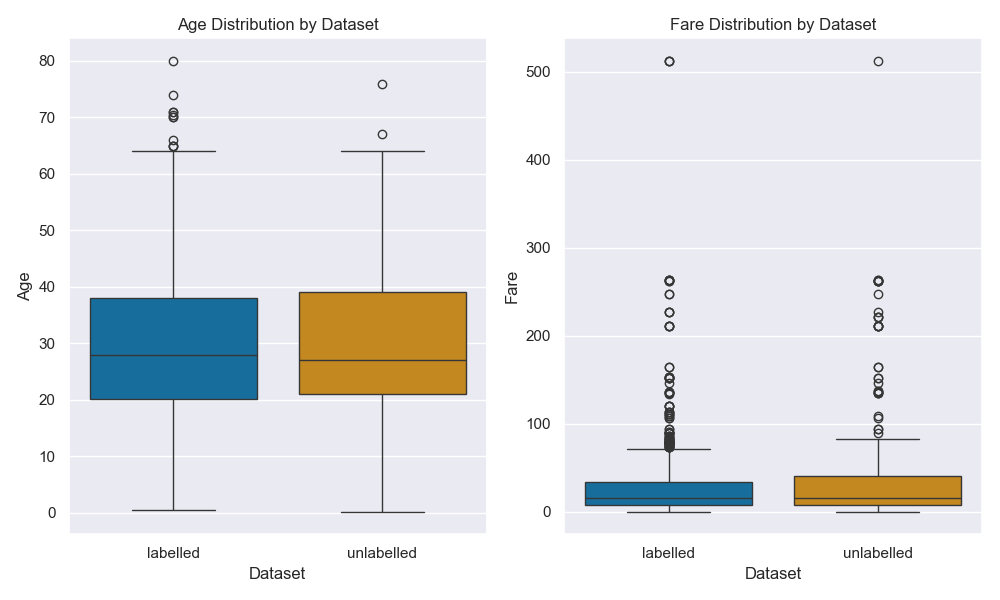

In [252]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

features = ['Age', 'Fare']
df_filtered = df_merged[df_merged[features].notnull().all(axis=1)]

for i,f in enumerate(features):
    sns.boxplot(data=df_filtered, x='Dataset', hue='Dataset', y=f, ax=axes[i])
    axes[i].set_title(f'{f} Distribution by Dataset')

plt.tight_layout()
plt.show()

As far as age is concerned, there are very few outliers very close to the upper whisker, both in the labelled set and in the unlabelled set; that is why we did not remove them. As for the rate, all values above 100 can be considered outliers, but the distribution between labelled and unlabelled set is the same, so we do not remove them.

## Fix or remove missing values

In [253]:
def find_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    total = df.isnull().sum().sort_values(ascending=False)
    percentage = total / len(df)
    missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])
    missing_data = missing_data[missing_data['Total'] > 0]
    return missing_data

find_missing_values(df_labelled)

,Total,Percentage
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


In [254]:
find_missing_values(df_unlabelled)

,Total,Percentage
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392


### `Cabin` missing values

Approximately 78% of the values in both the labelled set and the unlabelled set are missing; deducing this characteristic from the missing values would be impossible, so we drop the column.

In [255]:
df_labelled.drop(columns=['Cabin'], inplace=True)
df_unlabelled.drop(columns=['Cabin'], inplace=True)

### `Embarked` missing values

In [256]:
df_labelled[pd.isna(df_labelled['Embarked'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Family_size,Dataset,Title,First,Last,Ticket_prefix,Ticket_number,Ticket_len,Ticket_group_size,Ticket_number_bin
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,...,Single,labelled,Miss,Amelie,Icard,NoPrefix,113572,6,2,midhigh
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,...,Single,labelled,Mrs,George Nelson,Stone,NoPrefix,113572,6,2,midhigh


We can see that both passengers have `Pclass == 1` and `Fare == 80`, we cross the data and see from which port they might have embarked.

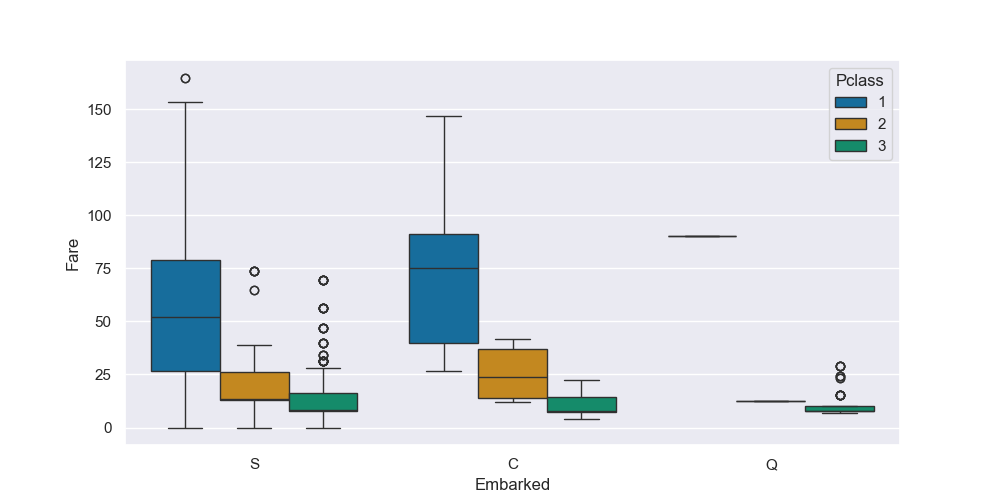

In [257]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=df_labelled[df_labelled['Fare'] < 200], x='Embarked', y='Fare', hue='Pclass', ax=ax, palette='colorblind')

plt.show()

As can be seen, those embarking from Cherbourg had a median fare closer to 80 for first passenger class than those embarking from Southampton. It is also true that those who embarked from Cherbourg had a better chance of survival than the others, in terms of port location. So let us fill in the values with C.

In [258]:
df_labelled['Embarked'] = df_labelled['Embarked'].fillna('C')

### `Fare` missing value

In [259]:
df_unlabelled[pd.isna(df_unlabelled['Fare'])]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Family_size,Dataset,Title,First,Last,Ticket_prefix,Ticket_number,Ticket_len,Ticket_group_size,Ticket_number_bin
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,...,Single,unlabelled,Mr,Thomas,Storey,NoPrefix,3701,4,1,low


The passengers boarded in Southampton and had a third class seat, so it makes sense he paid a fare close to the median of that class from that port.

In [260]:
median_fare = df_unlabelled.loc[(df_unlabelled['Pclass'] == 3) & (df_unlabelled['Embarked'] == 'S'), 'Fare'].median()
df_unlabelled['Fare'] = df_unlabelled['Fare'].fillna(median_fare)

### `Age` missing values

Instead of deleting the `Age' column from the entire dataset, as only 20 per cent of the ages are missing, we will try to fill these values through inference. The following function does exactly that. Let us analyse it step by step.
1. Take the complete dataset (concatenate the unlabelled and labelled sets) and create the labelled set with the rows where the age is null. Use the rest to create the unlabelled set.
2. Create the x_train, y_train and x_test sets. In this case we do not have a y_test to compare the results with. We will put our expected values in place of the missing ones.
3. The function then creates a pipeline:
    1. Machine learning algorithms work with numbers, so we convert each categorical feature using a One Hot Encoder and scale each numerical feature with the Standard Scaler,
    2. We apply a halved grid search to a pipeline with two steps: decomposition using PCA and regression with a model between SVR, Random Forest Regressor and Gradient Boosting Regressor. The halving strategy works by comparing the various models in parameter space and selecting a fraction of them at each iteration. The models start with a small amount of resources and receive more and more with each iteration.
4. R2 and R2 scores adjusted for the labelled set are then calculated to see how well they fit the labelled set.
5. We plot the scatter plot of the Age labelled set values and the predicted Age labelled set values, together with the bisector, which indicates the case where the model fits the labelled set well.
6. Finally, we predict the missing values and insert them into the merged original dataframe.

In [261]:
pd.concat([df_labelled, df_unlabelled], axis=0).loc[pd.isna(df_labelled['Age']) == False].shape

(1049, 23)

In [264]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection._search_successive_halving import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV

def fill_missing_age(df: pd.DataFrame, halving: bool=False) -> pd.DataFrame:
    rs = 42
    features = ['Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'Family_num',
       'Family_size', 'Title', 'Last', 'Ticket_prefix', 'Ticket_number_bin']
    
    age_df = df.loc[:,features]
    age_df_train = age_df.loc[pd.isna(age_df['Age']) == False]
    age_df_test = age_df.loc[pd.isna(age_df['Age']) == True]

    y_train = age_df_train['Age']
    x_train = age_df_train.drop(columns=['Age'])
    x_test = age_df_test.drop(columns=['Age'])

    cat_features = ['Sex', 'Embarked', 'Family_size', 'Title', 'Last', 'Ticket_prefix', 'Ticket_number_bin']
    num_features = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Family_num']

    ct = ColumnTransformer(
        transformers=[
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
            ('num', StandardScaler(), num_features)
        ]
    )

    param_grid = {
        # 'pca__n_components': [0.9, 0.95],
        'svd__n_components': [i for i in range(40, 100, 20)],
        'model__n_estimators': [500, 1000, 2000],
        # 'model__max_depth': [None, 20, 50],
        'model__min_samples_leaf': [1, 2],
        'model__max_features': ['sqrt', 'log2'],
        'model__bootstrap': [True]
    }

    if halving:
        pipeline = Pipeline(
            steps=[
                ('ct', ct),
                ('estimator', HalvingGridSearchCV(
                    Pipeline(
                        steps=[
                        # ('pca', PCA(20, random_state=rs)),
                        ('svd', TruncatedSVD()),
                        ('model', RandomForestRegressor(n_jobs=-1))
                    ]),
                    factor=2,
                    param_grid=param_grid,
                    min_resources='exhaust',
                    cv=5,
                    refit=True,
                    verbose=1,
                    aggressive_elimination=False
                ))
            ]
        )
    else:
        pipeline = Pipeline(
            steps=[
                ('ct', ct),
                ('estimator', GridSearchCV(
                    Pipeline(
                        steps=[
                        # ('pca', PCA(20, random_state=rs)),
                        ('svd', TruncatedSVD()),
                        ('model', RandomForestRegressor(n_jobs=-1))
                    ]),
                    param_grid=param_grid,
                    cv=5,
                    refit=True,
                    verbose=1,
                ))
            ]
        )

    # Fit the pipeline and predict
    pipeline.fit(x_train, y_train)
    y_train_pred = pipeline.predict(x_train)

    r2_score_train = pipeline.score(x_train, y_train)
    n = len(y_train)
    x_train_mod = ct.transform(x_train)
    x_train_mod = pipeline[-1].best_estimator_.named_steps['svd'].transform(x_train_mod)
    p = x_train_mod.shape[1]
    print(f"R2 scored for the labelled set: {r2_score_train}")
    print(f"Adjusted-R2 scored for the labelled set: {1 - (1 - r2_score_train) * (n - 1) / (n - p - 1)}")

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.scatterplot(x=y_train, y=y_train_pred, ax=ax)
    ax.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], c='red')
    ax.set_xlabel('Age labelled set')
    ax.set_ylabel('Age labelled set predicted')
    plt.show()
    
    # Fill missing ages in the original dataframe
    df.loc[pd.isna(df['Age']), 'Age'] = pipeline.predict(x_test).round(1)
    
    return df

Fitting 5 folds for each of 36 candidates, totalling 180 fits
R2 scored for the labelled set: 0.852646070082892
Adjusted-R2 scored for the labelled set: 0.8467812370513652


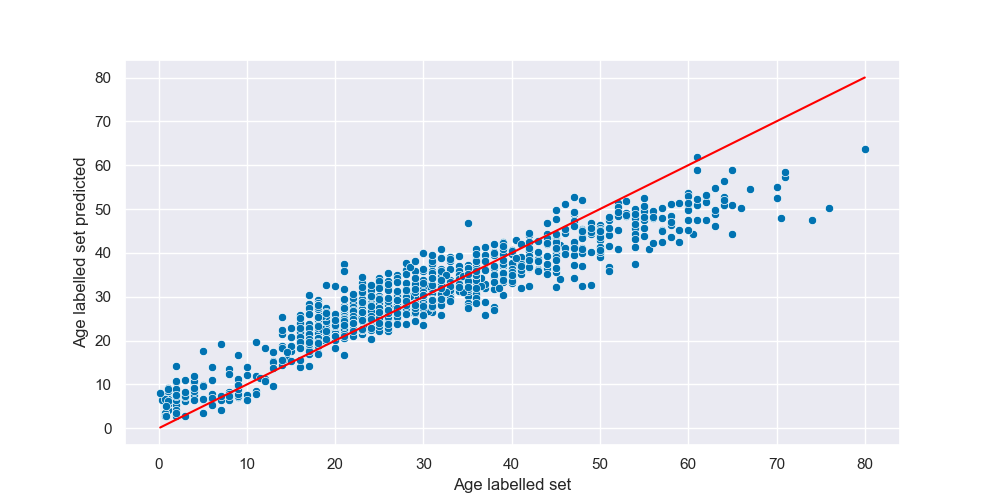

In [ ]:
df_merged = pd.concat([df_labelled, df_unlabelled], axis=0)
# df_merged = fill_missing_age(df_merged)

In [266]:
def age_category(age):
    if age < 13:
        return 'child'
    elif age >= 58:
        return 'senior'
    elif 13 <= age < 58:
        return 'adult'
    else:
        return 'no age'
    
df_merged['Age Category'] = df_merged['Age'].apply(age_category)

In [267]:
df_labelled = df_merged.loc[pd.isna(df_merged['Survived']) == False]
df_unlabelled = df_merged.loc[pd.isna(df_merged['Survived']) == True]

In [ ]:
# df_labelled.to_pickle('dataset\\labelled_age_fixed.pkl')
# df_unlabelled.to_pickle('dataset\\unlabelled_age_fixed.pkl')
df_labelled = pd.read_pickle('dataset\\labelled_age_fixed.pkl')
df_unlabelled = pd.read_pickle('dataset\\unlabelled_age_fixed.pkl')

## Feature Engineering - part 2

Now that there are no missing values, let us analyse the last two features, `Age` and `Fare`. To reduce the impact of outliers, we can discretize the two features, using the pandas qcut function, so that each bin is of equal size. The number of quantiles is determined by the following function, which sets the maximum number of bins, the minimum number of elements per bin, and the minimum number of positives (survivors == 1) per bin.

In [269]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method="yeo-johnson")

### Discretise `Age`

In [270]:
# tmp = pt.fit_transform(df_labelled[['Age']]).reshape(-1)
# pd.qcut(tmp, q=10, duplicates='drop').categories

C:\Users\bruno\AppData\Local\Temp\ipykernel_15872\755877148.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_labelled.groupby('Age_bin')['Survived']\


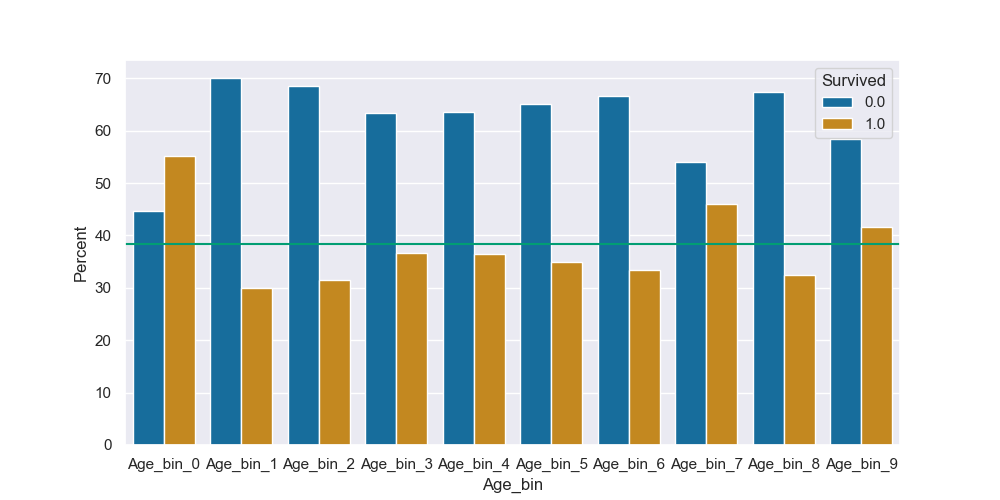

In [271]:
q = 10
tmp = pt.fit_transform(df_labelled[['Age']]).ravel()

# Derive intervals on labelled
age_q = pd.qcut(tmp, q=q, duplicates='drop')
intervals = age_q.categories
labels = [f'Age_bin_{i}' for i in range(len(intervals))]

# Assign labeled bins to labelled
df_labelled['Age_bin'] = pd.Categorical.from_codes(age_q.codes, categories=labels, ordered=True)

# Transform unlabelled ages
tmp_unlabelled = pt.transform(df_unlabelled[['Age']]).ravel()

# Numeric edges from IntervalIndex (extend lower if needed for unlabelled extremes)
bin_edges = [intervals[0].left] + [iv.right for iv in intervals]
bin_edges[0] = min(bin_edges[0], tmp_unlabelled.min())
bin_edges[-1] = max(bin_edges[-1], tmp_unlabelled.max())

df_unlabelled['Age_bin'] = pd.cut(
    tmp_unlabelled,
    bins=bin_edges,
    labels=labels,
    include_lowest=True,
    right=True
)

df_grouped = df_labelled.groupby('Age_bin')['Survived']\
    .value_counts(normalize=True)\
    .mul(100)\
    .rename('Percent')\
    .reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=df_grouped, x='Age_bin', hue='Survived', y='Percent', ax=ax)
ax.axhline(y=df_labelled['Survived'].mean()*100, color='g')
plt.show()

### Discretise `Fare`

C:\Users\bruno\AppData\Local\Temp\ipykernel_15872\588829120.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_labelled.groupby('Fare_bin')['Survived']\


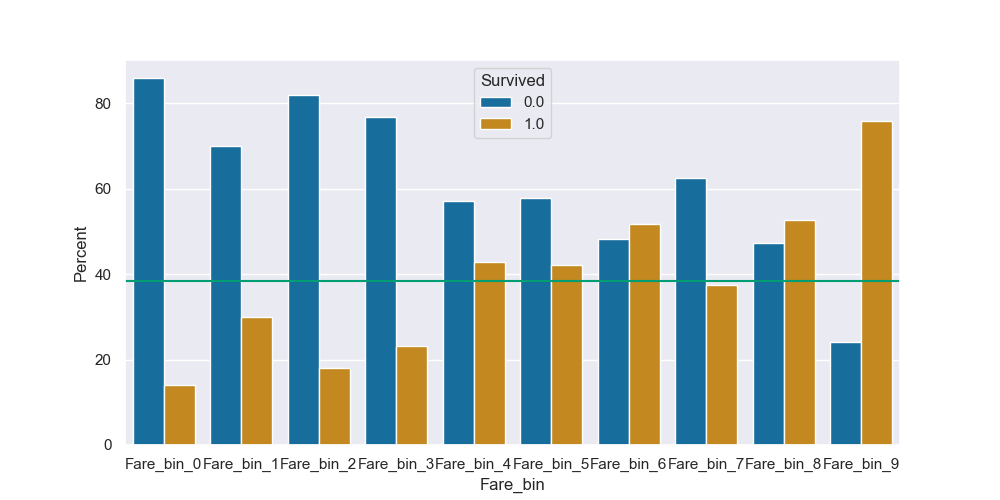

In [272]:
q = 10
tmp = pt.fit_transform(df_labelled[['Fare']]).ravel()

# Derive intervals on labelled
fare_q = pd.qcut(tmp, q=q, duplicates='drop')
intervals = fare_q.categories
labels = [f'Fare_bin_{i}' for i in range(len(intervals))]

# Assign labeled bins to labelled
df_labelled['Fare_bin'] = pd.Categorical.from_codes(fare_q.codes, categories=labels, ordered=True)

# Transform unlabelled fares
tmp_test = pt.transform(df_unlabelled[['Fare']]).ravel()

# Numeric edges from IntervalIndex (extend lower if needed for unlabelled extremes)
bin_edges = [intervals[0].left] + [iv.right for iv in intervals]
bin_edges[0] = min(bin_edges[0], tmp_test.min())
bin_edges[-1] = max(bin_edges[-1], tmp_test.max())

df_unlabelled['Fare_bin'] = pd.cut(
    tmp_test,
    bins=bin_edges,
    labels=labels,
    include_lowest=True,
    right=True
)

df_grouped = df_labelled.groupby('Fare_bin')['Survived']\
    .value_counts(normalize=True)\
    .mul(100)\
    .rename('Percent')\
    .reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=df_grouped, x='Fare_bin', hue='Survived', y='Percent', ax=ax)
ax.axhline(y=df_labelled['Survived'].mean()*100, color='g')
plt.show()

## Feature Scaling

The next step is to examine the characteristic for the presence of noise. Noise can result from two cases:
1. A feature is present in the labelled set and absent in the unlabelled set or vice versa.
2. The feature distribution is not close to a normal distribution, e.g. it is skewed.

### Case 1: Is there noise between labelled and unlabelled set?

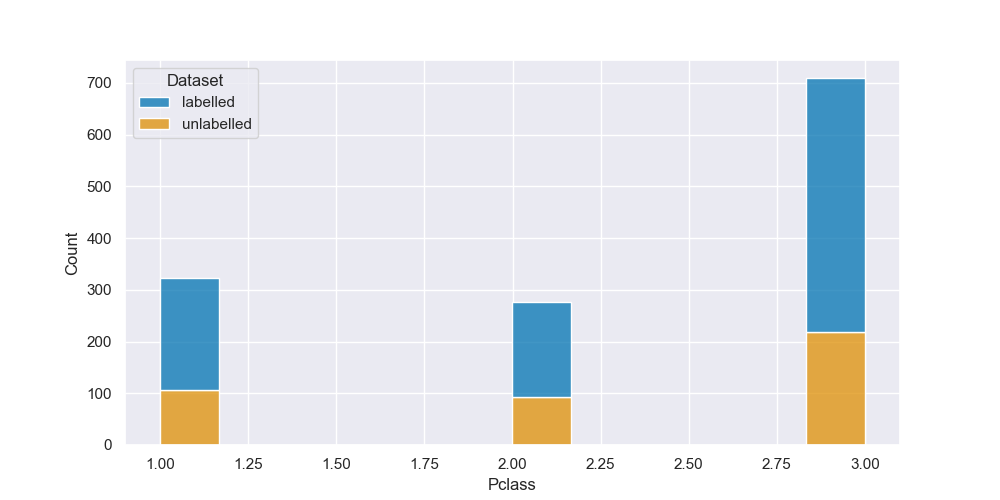

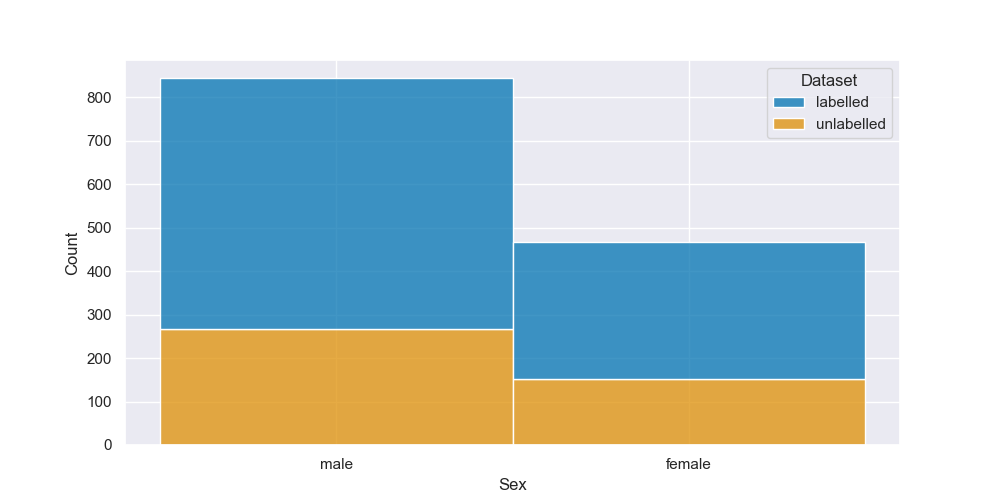

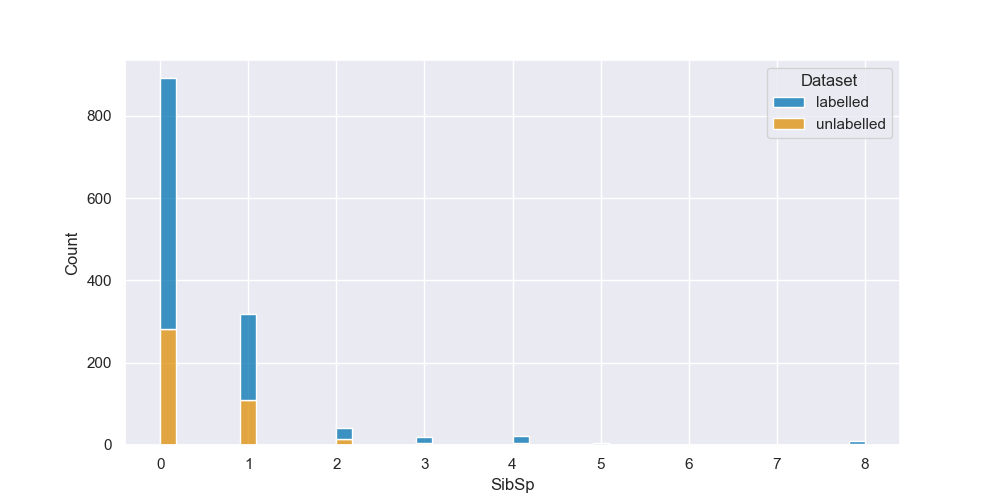

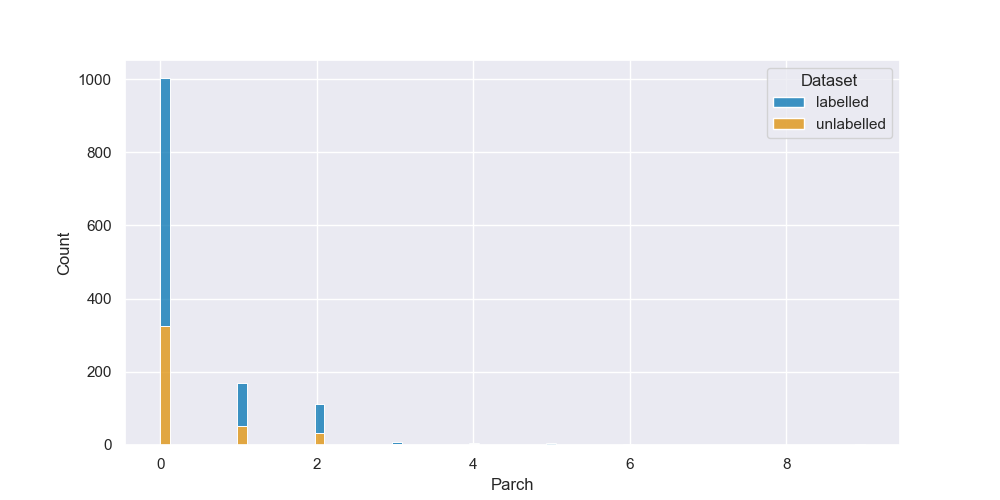

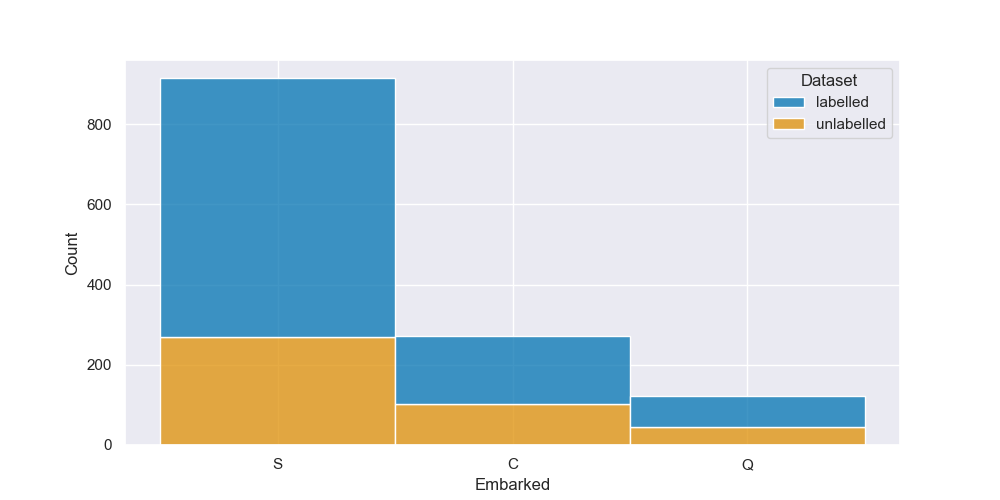

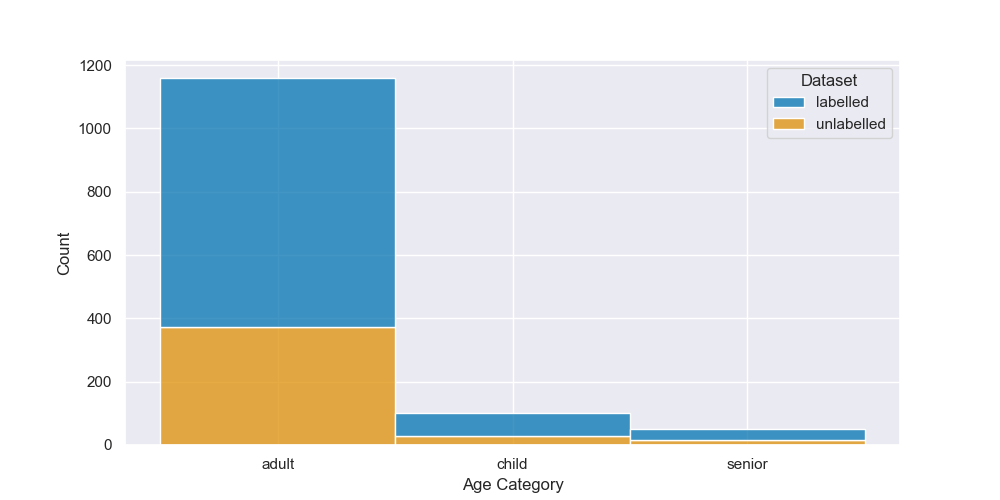

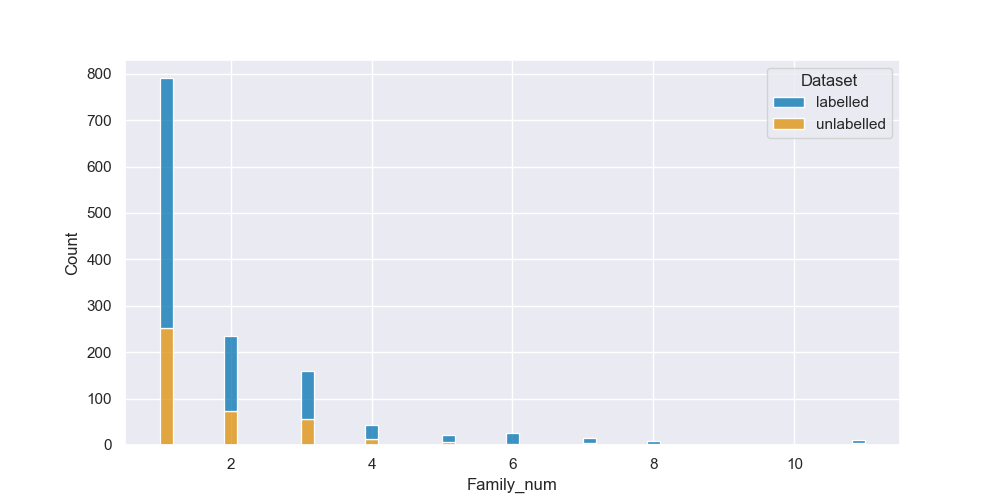

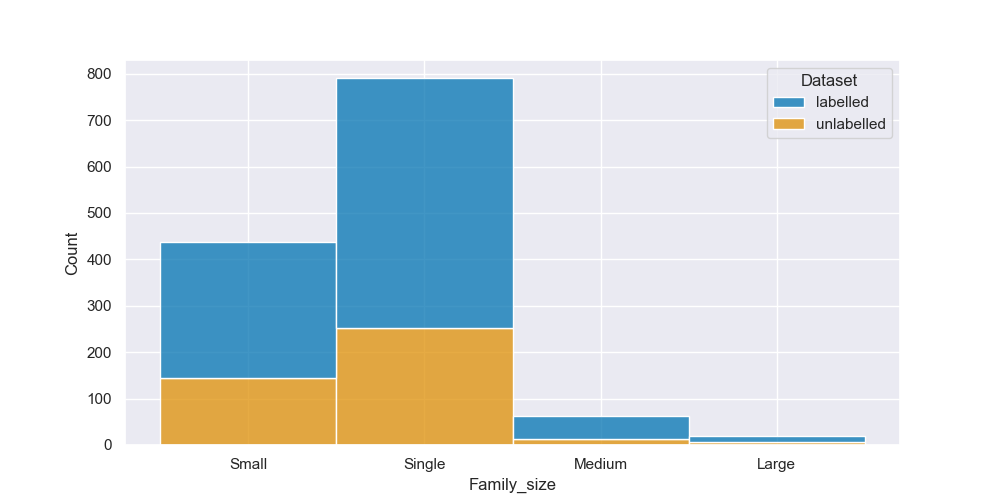

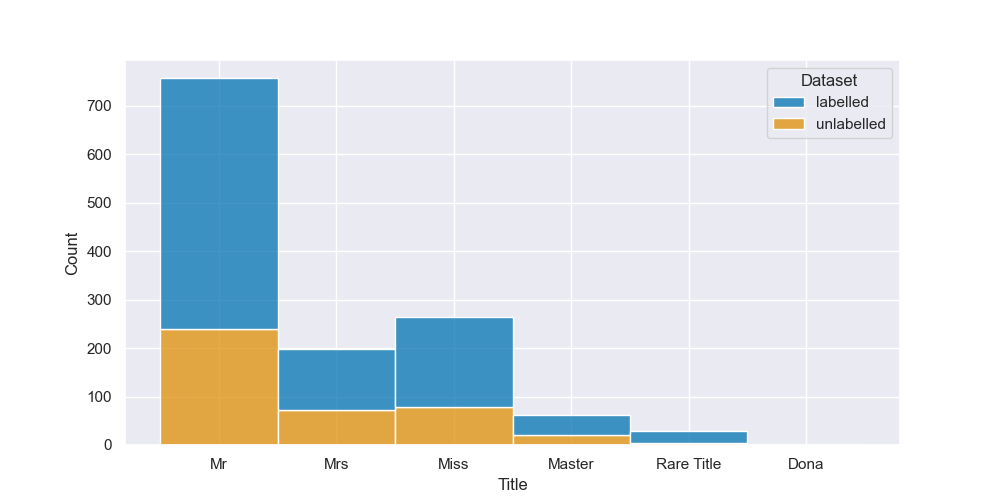

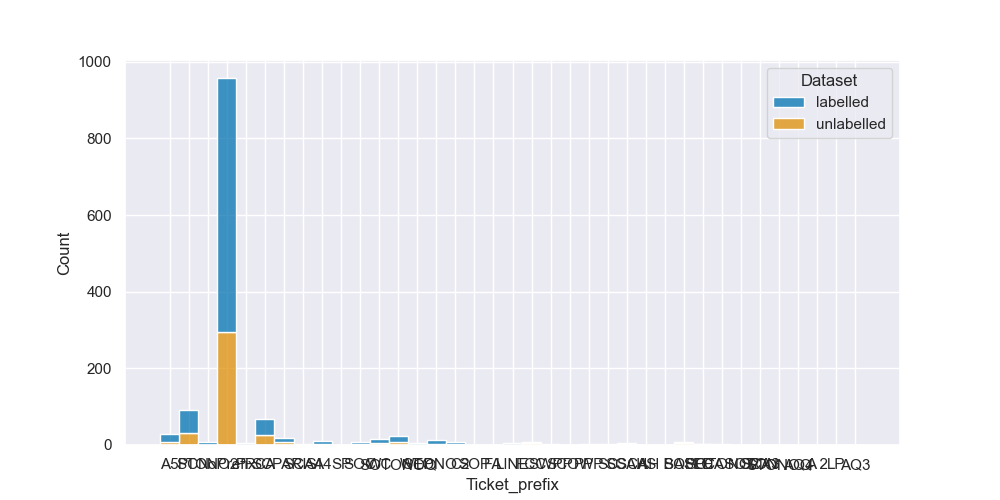

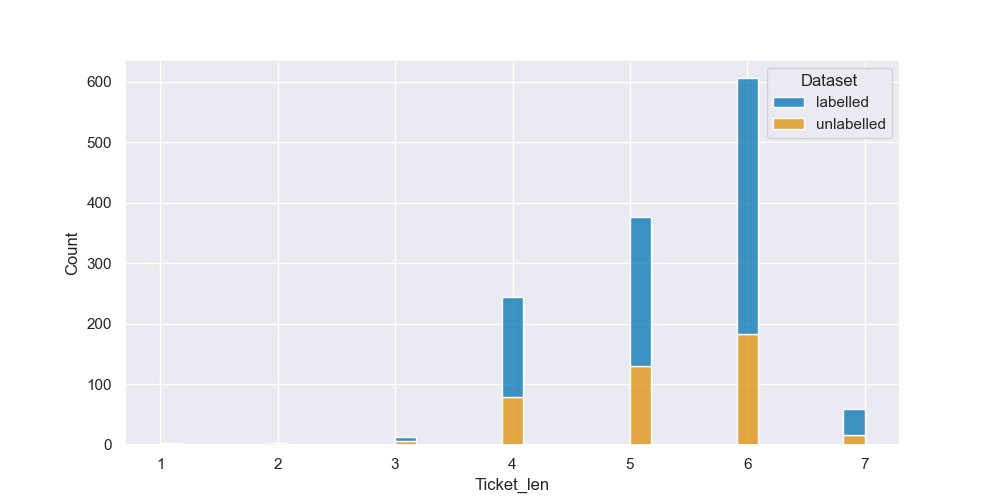

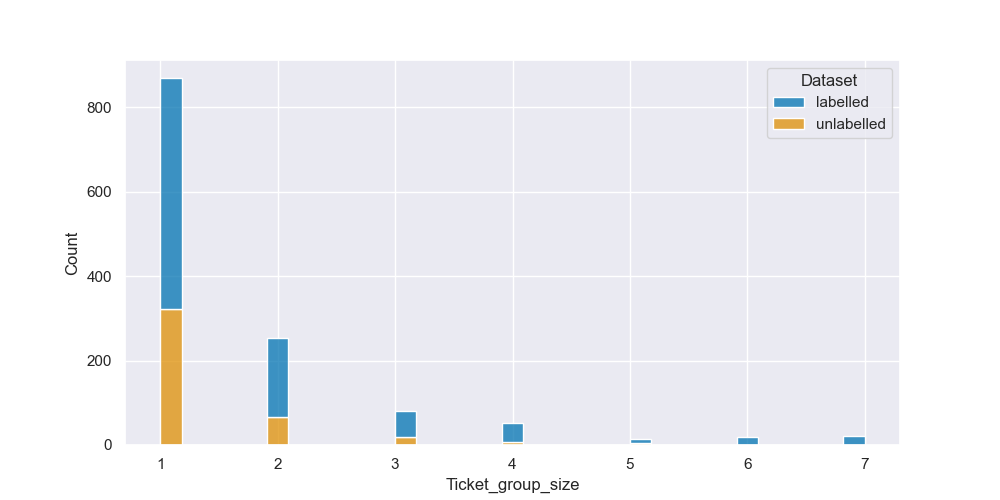

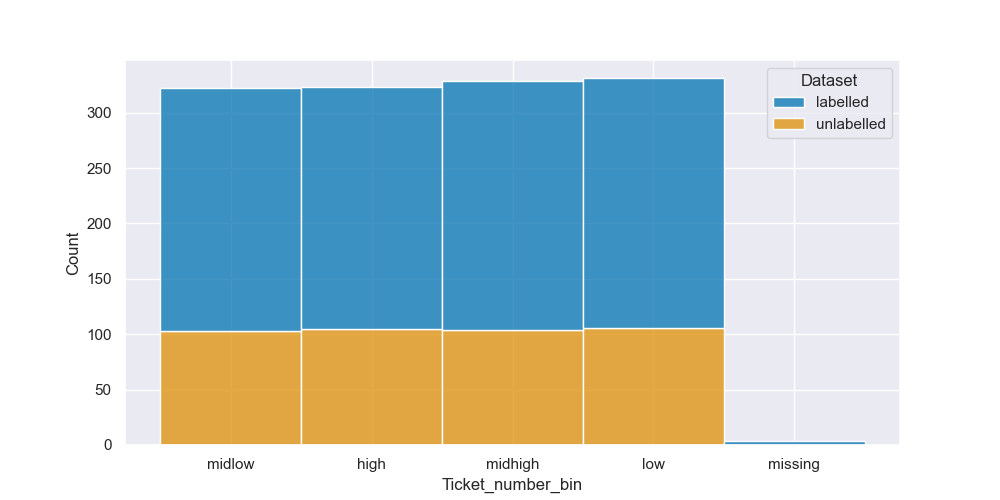

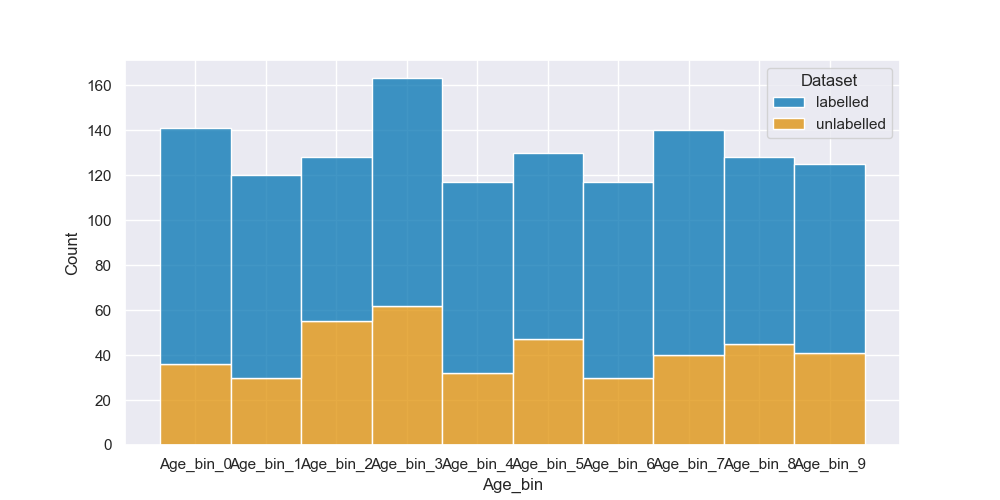

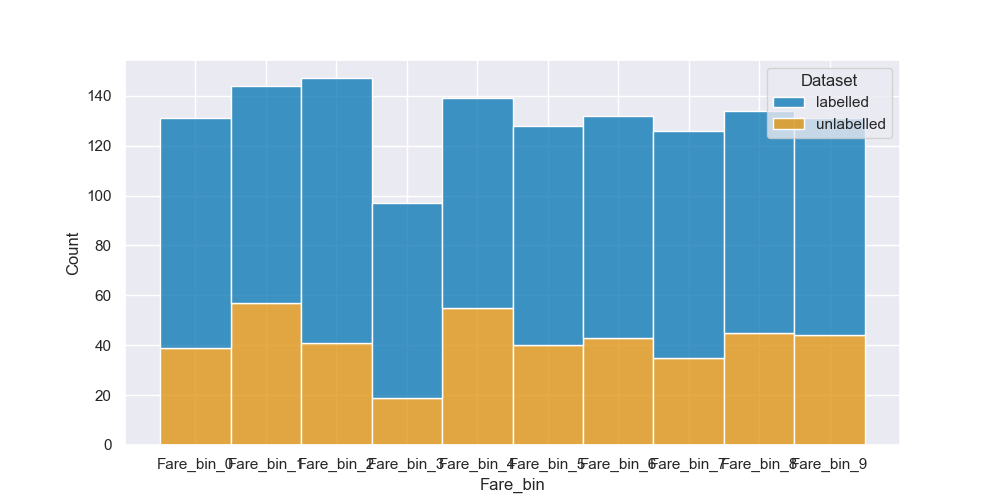

In [273]:
df_merged = pd.concat([df_labelled, df_unlabelled], axis=0)

for f in df_merged.columns:
    # We do not consider those features with more than 100 unique values
    # We do not consider 'Survived' because we know it's present only in the labelled set
    # We do not consider 'Dataset', because we created it only for visualisation
    if df_merged[f].nunique() < 100 and f != 'Survived' and f != 'Dataset':
        fig, axes = plt.subplots(figsize=(10,5))
        sns.histplot(data=df_merged, x=f, hue='Dataset', multiple='stack')
        plt.show()

All these feature are present in both labelled and unlabelled sets.

### Case 2: is there noise in the feature distribution?

In [274]:
df_merged['Age_bin'].dtype

CategoricalDtype(categories=['Age_bin_0', 'Age_bin_1', 'Age_bin_2', 'Age_bin_3',
                  'Age_bin_4', 'Age_bin_5', 'Age_bin_6', 'Age_bin_7',
                  'Age_bin_8', 'Age_bin_9'],
, ordered=True, categories_dtype=object)

In [275]:
from scipy.stats import skew

def compute_skewness(df: pd.DataFrame):
    # keep only numeric columns (exclude object and categorical)
    num_features = df.select_dtypes(include=[np.number]).columns
    skewed_features = pd.DataFrame(index=num_features, columns=['skewness', 'nunique_values'])
    skewed_features['skewness'] = df[num_features].apply(lambda x: skew(x))
    skewed_features['nunique_values'] = df.nunique()
    skewed_features = skewed_features[(skewed_features['skewness'] > 1) | (skewed_features['skewness'] < -1)].sort_values('skewness', ascending=False)
    return skewed_features

In [276]:
compute_skewness(df_merged)

,skewness,nunique_values
Fare,4.364205,281
Ticket_number,3.965701,924
SibSp,3.839814,7
Parch,3.664872,8
Family_num,2.849808,9
Ticket_group_size,2.501775,7


## Feature Selection

At this point we have to eliminate all those features that we consider useless or highly correlated with one or more other features and turn the categorical features into numerical ones.

First we remove the following: `PassengerId`, `Name`, `Dataset`, `First` from both the labelled and unlabelled sets. Then we also remove `Survived` from the unlabelled set (it was created when we tried to deduce the missing ages).

In [277]:
df_labelled.drop(['PassengerId', 'Name', 'Dataset', 'First'], axis=1, inplace=True)
df_unlabelled.drop(['PassengerId', 'Name',  'Dataset', 'Survived', 'First'], axis=1, inplace=True)

At this point we must transform categorical features into numerical ones, eliminate features that have very low variance, apply scaling and normalise highly skewed features to reduce the influence of outliers on the model.

In [278]:
from scipy.stats import entropy, skew

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.feature_selection import VarianceThreshold

In [279]:
def _is_low_dispersion_discrete(
    x,
    bernoulli_thresh=0.0475,
    entropy_thresh=0.3,
    freq_ratio_thresh=0.95,
):
    """
    Return True if the DISCRETE feature x shows "low dispersion":
    - almost constant (freq_ratio >= freq_ratio_thresh),
    - Bernoulli variance p(1-p) < bernoulli_thresh,
    - entropy < entropy_thresh.
    """
    x = np.asarray(x)
    n = len(x)
    if n == 0:
        return True

    unique_vals, counts = np.unique(x, return_counts=True)
    freq_ratio = counts.max() / n

    # Almost constant (>= 95% same value by default)
    if freq_ratio >= freq_ratio_thresh:
        return True

    # Bernoulli or quasi-binary: variance p(1-p)
    if len(unique_vals) == 2:
        p = counts[0] / n
        var = p * (1 - p)
        return var < bernoulli_thresh

    # Multi-level discrete: entropy
    probs = counts / n
    H = entropy(probs, base=2)
    return H < entropy_thresh


In [280]:
def _is_low_dispersion_continuous(
    x,
    cv_thresh=0.01,
    iqr_thresh=1e-3,
    freq_ratio_thresh=0.95,
    skew_thresh=None,
):
    """
    Return True if the CONTINUOUS feature x shows low dispersion or
    problematic distribution shape:
    - almost constant (freq_ratio >= freq_ratio_thresh),
    - low coefficient of variation (CV),
    - low IQR,
    - optional: skewness absolute value > skew_thresh.
    """
    x = np.asarray(x)
    n = len(x)
    if n == 0:
        return True

    x_nonan = x[~np.isnan(x)]
    if len(x_nonan) == 0:
        return True

    # Almost constant (>= 95% same value)
    unique_vals, counts = np.unique(x_nonan, return_counts=True)
    freq_ratio = counts.max() / len(x_nonan)
    if freq_ratio >= freq_ratio_thresh:
        return True

    mean = np.mean(x_nonan)
    std = np.std(x_nonan)

    # Coefficient of variation
    cv = std / (abs(mean) + 1e-9)

    # Interquartile range
    q25, q75 = np.percentile(x_nonan, [25, 75])
    iqr = q75 - q25

    # Optional skewness filtering
    if skew_thresh is not None:
        sk = skew(x_nonan)
        if abs(sk) > skew_thresh:
            return True

    if cv < cv_thresh or iqr < iqr_thresh:
        return True

    return False


In [281]:
class DiscreteDispersionFilter(BaseEstimator, TransformerMixin):
    """
    Remove DISCRETE features with low dispersion based on:
    - frequency ratio (constant-like),
    - Bernoulli variance p(1-p),
    - entropy.
    Works with pandas DataFrames when used inside ColumnTransformer.
    """
    def __init__(
        self,
        bernoulli_thresh=0.0475,
        entropy_thresh=0.3,
        freq_ratio_thresh=0.95,
    ):
        self.bernoulli_thresh = bernoulli_thresh
        self.entropy_thresh = entropy_thresh
        self.freq_ratio_thresh = freq_ratio_thresh

    def fit(self, X, y=None):
        # Ensure X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        self.keep_columns_ = []

        for col in X.columns:
            col_values = X[col].values
            low_disp = _is_low_dispersion_discrete(
                col_values,
                bernoulli_thresh=self.bernoulli_thresh,
                entropy_thresh=self.entropy_thresh,
                freq_ratio_thresh=self.freq_ratio_thresh,
            )
            if not low_disp:
                self.keep_columns_.append(col)

        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.keep_columns_ + [])
        # Keep only the selected discrete columns
        return X.loc[:, self.keep_columns_]

    def get_feature_names_out(self, *args, **params):
        return self.keep_columns_

In [282]:
class ContinuousDispersionFilter(BaseEstimator, TransformerMixin):
    """
    Remove CONTINUOUS features with low dispersion or problematic shape based on:
    - frequency ratio (constant-like),
    - coefficient of variation (CV),
    - IQR,
    - optional skewness constraint.
    Works with pandas DataFrames when used inside ColumnTransformer.
    """
    def __init__(
        self,
        cv_thresh=0.01,
        iqr_thresh=1e-3,
        freq_ratio_thresh=0.95,
        skew_thresh=None,  # e.g. 1.0 if you want to drop |skew|>1
    ):
        self.cv_thresh = cv_thresh
        self.iqr_thresh = iqr_thresh
        self.freq_ratio_thresh = freq_ratio_thresh
        self.skew_thresh = skew_thresh

    def fit(self, X, y=None):
        # Ensure X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        self.keep_columns_ = []

        for col in X.columns:
            col_values = X[col].values
            low_disp = _is_low_dispersion_continuous(
                col_values,
                cv_thresh=self.cv_thresh,
                iqr_thresh=self.iqr_thresh,
                freq_ratio_thresh=self.freq_ratio_thresh,
                skew_thresh=self.skew_thresh,
            )
            if not low_disp:
                self.keep_columns_.append(col)

        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.keep_columns_ + [])
        # Keep only the selected continuous columns
        return X.loc[:, self.keep_columns_]
    
    def get_feature_names_out(self, *args, **params):
        return self.keep_columns_

In [283]:
def select_features(
    df_labelled: pd.DataFrame,
    df_unlabelled: pd.DataFrame,
    target_col: str,
    continuous_features: list,
    discrete_features: list,
    categorical_features: list,
    # thresholds for discrete features
    bernoulli_thresh=0.0475,
    entropy_thresh=0.3,
    # thresholds for continuous features
    cv_thresh=0.01,
    iqr_thresh=1e-3,
    skew_thresh=None,      # e.g., 1.0 if you want to drop features with |skew| > 1
    # common "almost constant" threshold
    freq_ratio_thresh=0.95,
    # threshold for OHE dummy variance: p_min -> var_min = p_min * (1 - p_min)
    cat_min_freq=0.95,
):
    """
    Select and transform features using a ColumnTransformer, with all
    internal steps working on pandas DataFrames where applicable.

    Steps:
      - Continuous features: dispersion filter + Yeo–Johnson transform.
      - Discrete features: dispersion filter only.
      - Categorical features: One-Hot Encoding + variance threshold on dummy vars.

    Fitting is done on df_labelled; transformations are applied consistently to df_unlabelled.

    Returns:
        df_labelled_new: transformed labelled DataFrame (features + target)
        df_unlabelled_new:  transformed unlabelled DataFrame (features + target if present)
    """

    # Split labelled
    X_labelled = df_labelled.drop(columns=[target_col])
    y_labelled = df_labelled[target_col]

    # Split unlabelled (target optional)
    if target_col in df_unlabelled.columns:
        X_unlabelled = df_unlabelled.drop(columns=[target_col])
        y_unlabelled = df_unlabelled[target_col]
        has_test_target = True
    else:
        X_unlabelled = df_unlabelled.copy()
        has_test_target = False

    # Ensure we only use columns that are present in X_train
    cont_cols = [c for c in continuous_features if c in X_labelled.columns]
    disc_cols = [c for c in discrete_features if c in X_labelled.columns]
    cat_cols  = [c for c in categorical_features if c in X_labelled.columns]

    # 1. Continuous pipeline: dispersion filter -> PowerTransformer (Yeo–Johnson)
    numeric_pipeline = Pipeline(steps=[
        ("dispersion_cont", ContinuousDispersionFilter(
            cv_thresh=cv_thresh,
            iqr_thresh=iqr_thresh,
            freq_ratio_thresh=freq_ratio_thresh,
            skew_thresh=skew_thresh,
        )),
        ("yeojohnson", PowerTransformer(method="yeo-johnson", standardize=True)),
    ])

    # 2. Discrete pipeline: dispersion filter only
    discrete_pipeline = Pipeline(steps=[
        ("dispersion_disc", DiscreteDispersionFilter(
            bernoulli_thresh=bernoulli_thresh,
            entropy_thresh=entropy_thresh,
            freq_ratio_thresh=freq_ratio_thresh,
        ))
    ])

    # 3. Categorical pipeline: One-Hot -> variance threshold on Bernoulli dummies
    var_thresh_cat = cat_min_freq * (1.0 - cat_min_freq)

    categorical_pipeline = Pipeline(steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ("var_thresh", VarianceThreshold(threshold=var_thresh_cat)),
    ])

    # ColumnTransformer: it will pass DataFrame slices to transformers when X is a DataFrame
    preprocessor = ColumnTransformer(
        transformers=[
            ("num",  numeric_pipeline,   cont_cols),
            ("disc", discrete_pipeline,  disc_cols),
            ("cat",  categorical_pipeline, cat_cols),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
    )
    preprocessor.set_output(transform='pandas')

    # Fit on labelled data
    preprocessor.fit(X_labelled, y_labelled)

    # Transform labelled and unlabelled
    X_labelled_proc = preprocessor.transform(X_labelled)
    X_unlabelled_proc  = preprocessor.transform(X_unlabelled)

    # Build DataFrames with proper feature names
    feature_names = preprocessor.get_feature_names_out()

    df_labelled_new = pd.DataFrame(X_labelled_proc, columns=feature_names, index=df_labelled.index)
    df_labelled_new[target_col] = y_labelled.values

    df_unlabelled_new = pd.DataFrame(X_unlabelled_proc, columns=feature_names, index=df_unlabelled.index)
    if has_test_target:
        df_unlabelled_new[target_col] = y_unlabelled.values

    return df_labelled_new, df_unlabelled_new, preprocessor


In [284]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, PowerTransformer
# from sklearn.feature_selection import VarianceThreshold

# # AdaptiveVarianceThresholdDF
# # - Dynamic variance thresholding using quantiles
# # - Threshold = max(quantile(q), min_variance)
# # - More flexible than fixed thresholds
# class AdaptiveVarianceThresholdDF(BaseEstimator, TransformerMixin):
#     """Keep columns with variance >= max(quantile(q), min_variance)."""
#     def __init__(self, q: float=0.05, min_variance: float=1e-3):
#         self.q = float(q)
#         self.min_variance = float(min_variance)

#     def fit(self, X: pd.DataFrame, y=None):
#         vars_ = X.var(axis=0, numeric_only=True).to_numpy()
#         thr_q = float(np.quantile(vars_, self.q))
#         self.threshold_ = max(thr_q, self.min_variance)
#         self.support_mask_ = vars_ >= self.threshold_
#         if not np.any(self.support_mask_):
#             self.support_mask_[int(np.argmax(vars_))] = True
#         self.selected_columns_ = list(X.columns[self.support_mask_])
#         return self
    
#     def transform(self, X: pd.DataFrame):
#         return X.loc[:, self.selected_columns_]
    
#     def get_feature_names_out(self, *args, **params):
#         return self.selected_columns_

# # SkewedPowerTransformerDF
# # - Applies Yeo-Johnson transformation only to highly skewed features (|skew| > threshold)
# # - Selective normalization to preserve non-skewed distributions
# class SkewedPowerTransformerDF(BaseEstimator, TransformerMixin):
#     """Apply PowerTransformer only to columns with |skew| > skew_threshold."""
#     def __init__(self, skew_threshold: float = 1.0, method: str = "yeo-johnson", standardize: bool = True):
#         self.skew_threshold = float(skew_threshold)
#         self.method = method
#         self.standardize = bool(standardize)

#     def fit(self, X: pd.DataFrame, y=None):
#         self.input_features_ = list(X.columns)
#         skew = X.skew(axis=0, numeric_only=True)
#         skew_abs = skew.reindex(self.input_features_).abs().fillna(0.0)
#         mask = skew_abs > self.skew_threshold
#         self.selected_columns_ = [col for col, sel in zip(self.input_features_, mask.to_numpy()) if sel]
#         if len(self.selected_columns_) > 0:
#             self.pt_ = PowerTransformer(standardize=self.standardize)
#             self.pt_.fit(X[self.selected_columns_].to_numpy())
#         else:
#             self.pt_ = None
#         return self

#     def transform(self, X: pd.DataFrame):
#         X_out = X.copy()
#         if self.pt_ is not None and len(self.selected_columns_) > 0:
#             X_out.loc[:, self.selected_columns_] = self.pt_.transform(X_out[self.selected_columns_].to_numpy())
#         return X_out

#     def get_feature_names_out(self, *args, **kwargs):
#         return np.array(self.input_features_)

# # preprocess_df():
# # A preprocessing function that:
# # - Handles multiple column types: categorical, ordinal, continuous, discrete low-cardinality
# # - Creates specialized pipelines for each data type:
# #     - Categorical: OneHotEncoder → variance filtering for rare categories
# #     - Ordinal: OrdinalEncoder → MinMaxScaler  
# #     - Continuous: variance filtering → MinMaxScaler → adaptive variance → conditional power transform
# #     - Discrete: variance filtering → MinMaxScaler
# def preprocess_df(
#     df_labelled: pd.DataFrame,
#     df_unlabelled: pd.DataFrame,
#     target_col: str,
#     cat_cols,
#     ord_cols,
#     cont_cols,
#     disc_lo_cols,
#     q_numeric: float = 0.05,          # bottom 5% variance dropped (after MinMax)
#     min_variance_numeric: float = 1e-3,
#     rare_level_cut: float = 0.95,     # used to compute the binary-variance threshold
#     ohe_min_freq: float = 0.01        # group rare levels before OHE
# ) -> Tuple[pd.DataFrame, pd.DataFrame, ColumnTransformer]:
#     """
#     Fit preprocessing on df_labelled and return (df_labelled_df, df_unlabelled_df, fitted_preprocessor).
#     Assumes inputs are DataFrames and there are no missing values.
#     Removes target column from df_labelled (and df_unlabelled if present), then appends it back as the last column.
#     """

#     # Split out target from labelled (and unlabelled if present)
#     ytr = None
#     if target_col is not None and target_col in df_labelled.columns:
#         ytr = df_labelled[target_col]
#         Xtr_in = df_labelled.drop(columns=[target_col])
#     else:
#         Xtr_in = df_labelled

#     if target_col is not None and target_col in df_unlabelled.columns:
#         yte = df_unlabelled[target_col]
#         Xte_in = df_unlabelled.drop(columns=[target_col])
#     else:
#         yte = None
#         Xte_in = df_unlabelled

#     # --- thresholds inside the function ---
#     # Variance of a Bernoulli(p) is p(1-p); to drop dummies that are 95% same value:
#     vt_dummy = float(rare_level_cut*(1.0-rare_level_cut))  # 0.95*(1-0.95)=0.0475

#     # --- categorical pipeline (OHE -> drop near-constant dummies) ---
#     cat_pipe = Pipeline([
#         ("ohe", OneHotEncoder(handle_unknown="ignore",
#                               sparse_output=False,
#                               min_frequency=ohe_min_freq)),
#         ("vt_rare", VarianceThreshold(threshold=vt_dummy))
#     ])

#     # --- ordinal numeric (keep numeric scale; light normalization) ---
#     ord_pipe = Pipeline([
#         ("ord", OrdinalEncoder()),
#         ("vt_const", VarianceThreshold(threshold=0.0)),
#         ("minmax", MinMaxScaler())
#     ])

#     # --- continuous numeric (const drop -> MinMax -> adaptive var -> conditional Yeo–Johnson) ---
#     cont_pipe = Pipeline([
#         ("vt_const", VarianceThreshold(threshold=0.0)),
#         ("minmax", MinMaxScaler()),
#         ("vt_adapt", AdaptiveVarianceThresholdDF(q=q_numeric,
#                                                  min_variance=min_variance_numeric)),
#         ("pt_skew", SkewedPowerTransformerDF(skew_threshold=1.0, method="yeo-johnson"))
#     ])

#     # --- discrete low-cardinality (choose treatment) ---
#     disc_lo_pipe = Pipeline([
#         ("vt_const", VarianceThreshold(threshold=0.0)),
#         ("minmax", MinMaxScaler())
#     ])

#     # --- combine all columns ---
#     preproc = ColumnTransformer(
#         transformers=[
#             ("cat",  cat_pipe,        list(cat_cols)),
#             ("ord",  ord_pipe,        list(ord_cols)),
#             ("cont", cont_pipe,       list(cont_cols)),
#             ("disc", disc_lo_pipe,    list(disc_lo_cols)),
#         ],
#         remainder="drop",
#         verbose_feature_names_out=False
#     )
#     preproc.set_output(transform="pandas")

#     # --- fit + transform inside the function ---
#     Xtr_df = preproc.fit_transform(Xtr_in)
#     Xte_df = preproc.transform(Xte_in)

#     # Append target as the last column (if available)
#     if ytr is not None:
#         Xtr_df.insert(len(Xtr_df.columns), target_col, ytr.reindex(Xtr_df.index).to_numpy())
#     if yte is not None:
#         Xte_df.insert(len(Xte_df.columns), target_col, yte.reindex(Xte_df.index).to_numpy())

#     return Xtr_df, Xte_df, preproc

In [285]:
target_col = 'Survived'
cat_cols = df_labelled.dtypes[df_labelled.dtypes == 'object'].index.tolist() + ['Pclass', 'Fare_bin', 'Age_bin']
cont_cols = ['Age', 'Fare']
disc_cols = ['SibSp', 'Parch', 'Family_num', 'Ticket_len', 'Ticket_group_size']

In [286]:
df_labelled_mod, df_unlabelled_mod, preprocessor = select_features(
    df_labelled,
    df_unlabelled,
    target_col=target_col,
    continuous_features=cont_cols,
    discrete_features=disc_cols,
    categorical_features=cat_cols,
    cv_thresh=0.02,
    iqr_thresh=1e-4,
    skew_thresh=None,   # oppure 1.0 se vuoi scartare |skew|>1
    cat_min_freq=0.95,
)

In [287]:
# df_labelled_mod.to_pickle('dataset\\df_labelled_prepared.pkl')
# df_unlabelled_mod.to_pickle('dataset\\df_unlabelled_prepared.pkl')
df_labelled = pd.read_pickle('dataset\\df_labelled_prepared.pkl')
df_unlabelled = pd.read_pickle('dataset\\df_unlabelled_prepared.pkl')

### Remove highly correlated features

If two or more features have a high correlation, only one feature adds information to the machine learning algorithm. Multiple features with a high correlation can lead to overfitting, Therefore, we calculate the Pearson correlation between each feature and delete features that have an absolute correlation higher than 0.9.

In [288]:
corr_matrix = df_labelled.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

high_corr_f = [column for column in upper.columns if any((upper[column] > 0.9) | (upper[column] < -0.9))]

for f in high_corr_f:
    column_list = list(df_labelled.columns[
        np.where((df_labelled.corrwith(df_labelled[f]) > 0.9) |
        (df_labelled.corrwith(df_labelled[f]) < -0.9))
    ])
    column_list.remove(f)
    for column in column_list:
        print(f"{f} <-> {column}: {df_labelled[f].corr(df_labelled[column])}")

Sex_male <-> Sex_female: -0.9999999999999999


As we can see `Sex_male` has very high correlation, so we can delete it

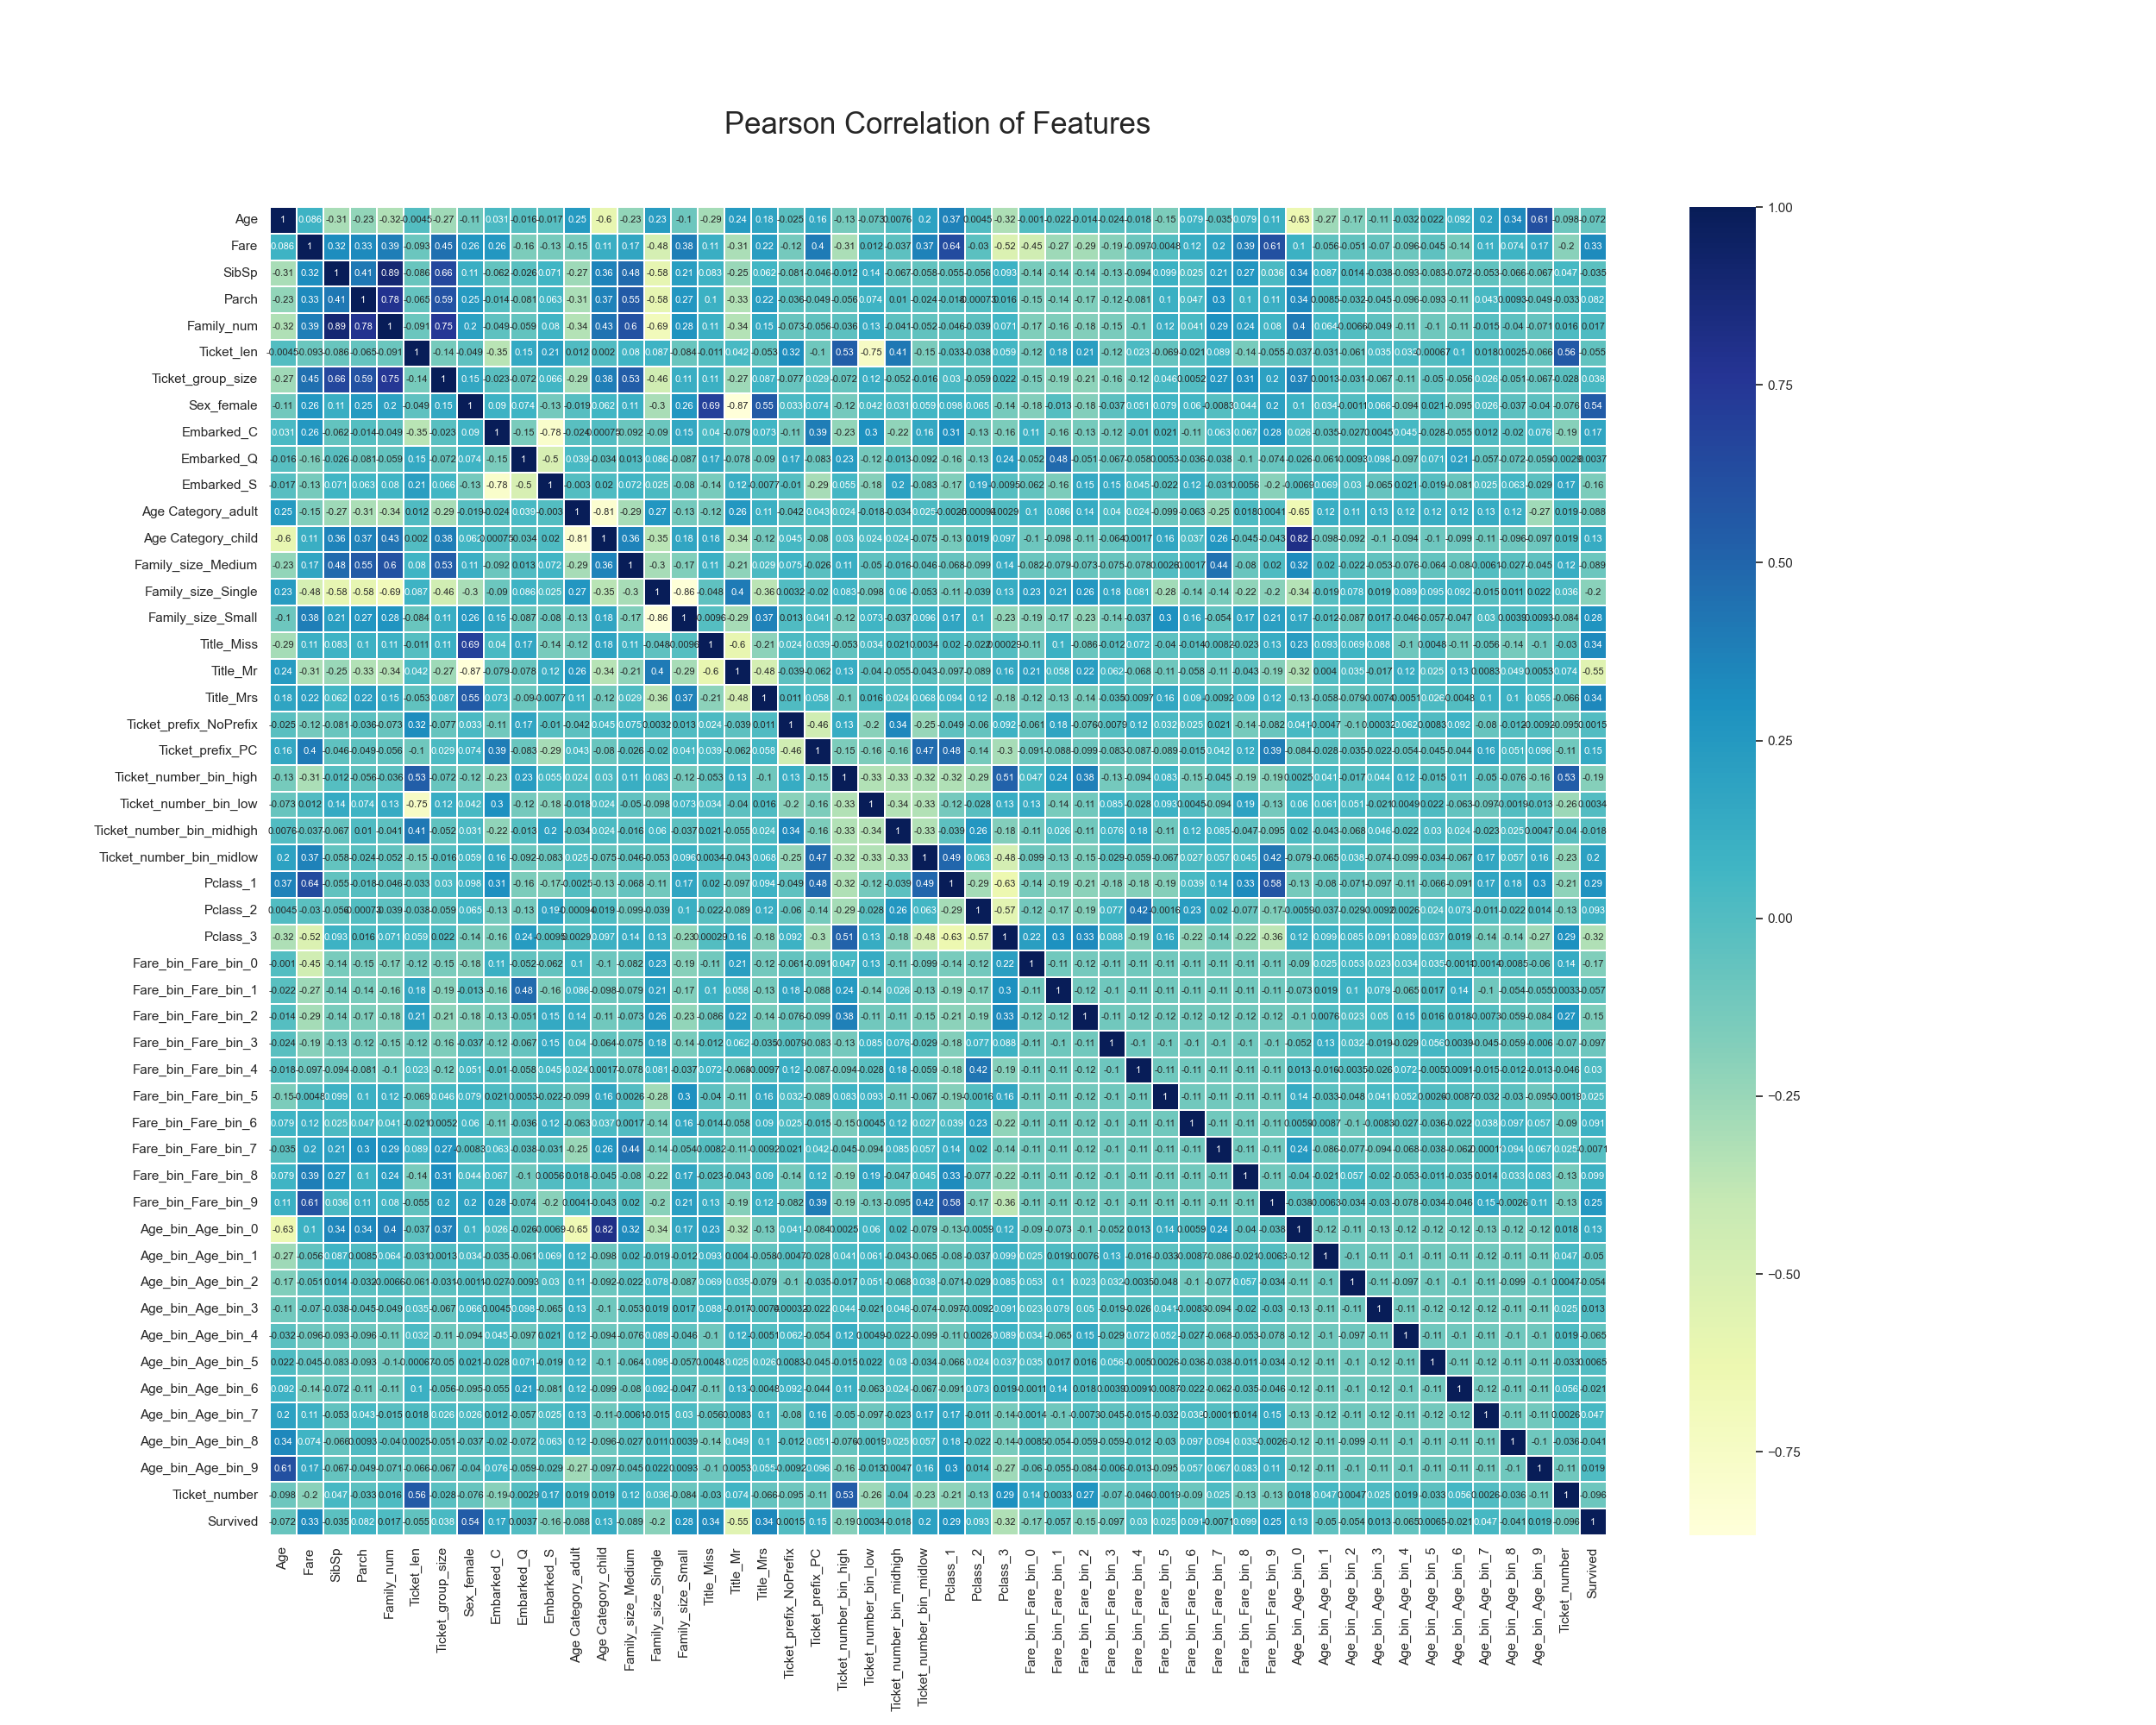

In [289]:
df_labelled.drop(['Sex_male'], axis=1, inplace=True)
df_unlabelled.drop(['Sex_male'], axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(25,20))
ax.set_title('Pearson Correlation of Features', y=1.05, size=25)
sns.heatmap(df_labelled.corr(), linewidths=0.1, vmax=1.0, square=False, linecolor='white', annot=True, annot_kws={"fontsize":8}, cmap="YlGnBu", ax=ax)
plt.show()

In [290]:
df_labelled.to_pickle('dataset\\df_labelled_prepared_reduced.pkl')
df_unlabelled.to_pickle('dataset\\df_unlabelled_prepared_reduced.pkl')